# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction 
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2


def batch_simulator(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and augmentation by zeros/ones
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data 

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [5]:
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.

In [6]:
generative_model = GenerativeModel(prior, batch_simulator)

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True,
)

In [8]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
    learning_rate = lr_schedule,
    checkpoint_path = './CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts',
    max_to_keep=300,
    skip_checks=True
)

Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


## Computational faithfulness

In [11]:
# Demo dataset
param_prior = np.array([[-0.7747589, -0.7236521]])
result = [np.array([-3.23788010e-04,  4.09819164e-01,  4.91645435e-01]), np.array([0, 2]), np.array([ 0., 10.]), np.array([0])]

sim_data = np.ones((1, n_obs, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([-1.0, 0.0])
result[3] = sim_data

x_data = result[3]   
n_post_samples = 7500   
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior

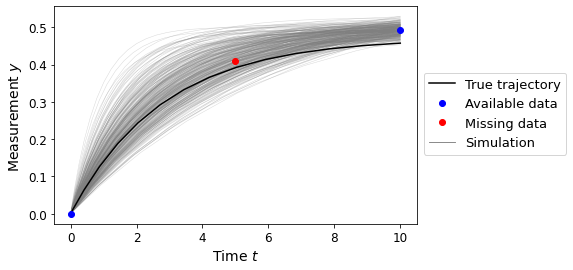

In [12]:
# Posterior predictive check
fig = plt.figure(figsize=(6.5, 4))
plt.rcParams['font.size'] = 12

for k in range(301):
    rhs = lambda t,x: conversion_reaction(t, x, param_samples[k])
    sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
    if k == 0:
        plt.plot(sol.t[0], sol.y[1][0], color='grey', label='Simulation', linewidth=0.9)
    else: 
        plt.plot(sol.t, sol.y[1], color='grey', linewidth=0.5, alpha=0.3)

rhs = lambda t,x: conversion_reaction(t, x, param_prior[0])
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='black', label='True trajectory')    
present_indices = result[1]
missing_indices = np.setdiff1d(range(n_obs), present_indices)
plt.plot(time_points[present_indices], result[0][present_indices], 'o', color='blue', label='Available data')
plt.plot(time_points[missing_indices], result[0][missing_indices], 'o', color='red', label='Missing data')

plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('Measurement $y$', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=13, bbox_to_anchor=(1.43,0.725))
plt.show()
fig.savefig("figures/{}_Re-simulation.png".format('CR3_no_ability'), dpi=600, bbox_inches='tight')

In [13]:
def prior_eval(x,y):   
    # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
    return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

def likelihood_ignore(x,y):   
    # Calculates likelihood p(x_{1:N} | theta) by ignoring the missing data
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(result[2])
    residual = (result[0][result[1]] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior_ignore(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood_ignore(x,y) * prior_eval(x,y)

def likelihood_original(x,y):   
    # Calculates likelihood p(x_{1:N} | theta) by using the original data
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(time_points)
    residual = (result[0] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior_original(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood_original(x,y) * prior_eval(x,y)

In [14]:
# scaling factor
scaling_factor_ignore = dblquad(unnormalized_posterior_ignore, -2.5, 1., lambda y: -2.5, lambda y: 1.)
print(scaling_factor_ignore)
scaling_factor_original = dblquad(unnormalized_posterior_original, -2.5, 1., lambda y: -2.5, lambda y: 1.)
print(scaling_factor_original)

# normalized posterior
posterior_xy_ignore = lambda x,y: unnormalized_posterior_ignore(x,y)/scaling_factor_ignore[0]
posterior_xy_original = lambda x,y: unnormalized_posterior_original(x,y)/scaling_factor_original[0]

(53.373335365118415, 9.331002053247772e-07)
(442.40161388073165, 1.9214177350248022e-05)


In [68]:
mean_sample = np.mean(param_samples, axis=0)
cov_sample = np.cov(param_samples.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

grid = 301
A = np.linspace(mean_x-4*std_x, mean_x+5*std_x, grid)
B = np.linspace(mean_y-5*std_y, mean_y+4*std_y, grid)
bounds = np.array([-2.5, 1., -2.5, 1.])

marginal_x_ignore = np.zeros(grid)
marginal_x_original = np.zeros(grid)
for i in range(grid):
    x = A[i]
    integrand_y_ignore = lambda y: posterior_xy_ignore(x, y)
    marginal_x_ignore[i] = quad(integrand_y_ignore, bounds[2], bounds[3])[0]
    integrand_y_original = lambda y: posterior_xy_original(x, y)
    marginal_x_original[i] = quad(integrand_y_original, bounds[2], bounds[3])[0]
    
marginal_y_ignore = np.zeros(grid)
marginal_y_original = np.zeros(grid)
for j in range(grid):
    y = B[j]
    integrand_x_ignore = lambda x: posterior_xy_ignore(x, y)
    marginal_y_ignore[j] = quad(integrand_x_ignore, bounds[0], bounds[1])[0]
    integrand_x_original = lambda x: posterior_xy_original(x, y)
    marginal_y_original[j] = quad(integrand_x_original, bounds[0], bounds[1])[0]

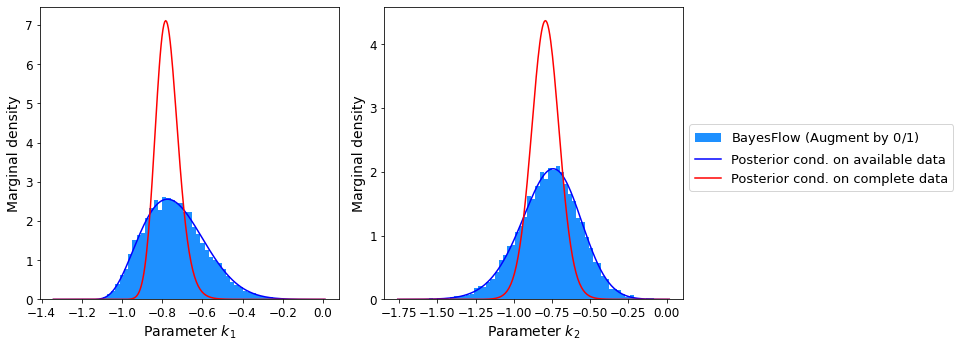

In [81]:
fig = plt.figure(figsize=(13.5, 5))
plt.rcParams['font.size'] = 12 
    
plt.subplot(1, 2, 1)
plt.hist(param_samples[:, 0], bins='auto', density=1, color='dodgerblue')
plt.plot(A, marginal_x_ignore, color='blue')
plt.plot(A, marginal_x_original, color='red')
plt.ylabel('Marginal density', fontsize=14)
plt.xlabel('Parameter $k_1$', fontsize=14)

plt.subplot(1, 2, 2)
plt.hist(param_samples[:, 1], bins='auto', density=1, color='dodgerblue', label='BayesFlow (Augment by $0/1$)')
plt.plot(B, marginal_y_ignore, color='blue', label='Posterior cond. on available data')
plt.plot(B, marginal_y_original, color='red', label='Posterior cond. on complete data')
plt.ylabel('Marginal density', fontsize=14)
plt.xlabel('Parameter $k_2$', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=13, bbox_to_anchor=(1,0.62))
    
plt.tight_layout()
plt.show()
fig.savefig("figures/{}_marginal.png".format('CR3_no_ability'), dpi=600, bbox_inches='tight')    